In [1]:
import os
import json
import yaml
import torch
import random
import detectron2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import wandb
import tensorboard

from train import get_dataset_dicts, get_dataset_dicts_with_regions, random_visu, setup_cfg, MyTrainer, load_json_arr, find_best_model

import shutil

In [2]:
# Check tb to avoid error during training #check if you need 1.15.0
tensorboard.__version__

'2.12.0'

In [3]:
#Verify GPU information
print (torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0)
       , torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using CUDA
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [4]:
### Set up ###

## Name annotations.json file in train and val ##
annotation_json = "via_region_data_with_empty_annotations.json"
experiment_name = "lr001_BS4_empty-annot-25_test-4"
conf_name = "NSOD2cfg_1000_169r_1000pix_noBT_" + experiment_name
conf_file = conf_name + ".yaml"

# Create a new output directory for output and metrics, if it doesn't exist
out_dir = "../Satellite/output/" + experiment_name
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print ("The new out_dir directory is created!")

## Evaluation
# If test set is val:
val_coco_json = "val_coco_format.json"

In [5]:
### ARGS ###


## D2 Configuration Args ##
base_model_ = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
trains_ = ("train",)
tests_ = ("val",)
workers_ = 2
base_lr_ = 0.001
eval_period_ = 1000
warm_iter_ = 200
ims_per_batch_ = 4
max_iter_ = 90000
out_dir_ = out_dir
filter_empty_annot_ = False

## Patience for early stopping ##
num_patience = 10

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
import os

# Define classes based on the unique types in the dataset
classes = ["container"]

# Assign a unique color to each class (you may want to choose these colors manually if specific colors are required)
colors = [(249, 180, 45)]

# Register dataset and metadata
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: 
        get_dataset_dicts(os.path.join("../Satellite", d), "annotation_json"))
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors

In [7]:
### Visualise annotations & images of trainning dataset ###

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../Satellite/train", annotation_json)    
random_visu(dataset_dicts, metadata, 1)

In [8]:
### Make D2 configuration  ###

cfg = setup_cfg(base_model=base_model_, trains=trains_, tests=tests_, workers=workers_, base_lr=base_lr_, eval_period=eval_period_, warm_iter=warm_iter_,
                ims_per_batch=ims_per_batch_, max_iter=max_iter_, out_dir=out_dir_, filter_empty_annot=filter_empty_annot_)
# update_model arg can be used to load already trained model
#cfg.INPUT.MIN_SIZE_TRAIN = 1000

# Save your configurations
with open(os.path.join(out_dir, conf_file), "w") as file:
    yaml.dump(cfg, file)
print(cfg.dump())

In [9]:
### Set up logging with Wandb ###

## If cfg is not defined, load it from yaml file: ##
#config = load_yaml(os.path.join(out_dir, conf_file))
#wandb.login()

# COMMENT OUT: AttributeError: module 'cgi' has no attribute 'escape': requirements tensorboard>=2.4.0 #167
#%load_ext tensorboard
#%tensorboard --logdir output

# Give the same name as output subfolder and confname - no need for wandb.login() at beginning if wand.init() is used
os.environ["WANDB_NOTEBOOK_NAME"] = "config_train_evaluate.ipynb"
wandb.init(
    project='P1',
    sync_tensorboard=True,
    save_code=True,
    config=cfg,
    name=experiment_name,
    notes=annotation_json,
    settings=wandb.Settings(
        start_method="thread",
        console="off"
    )
)

# Never worked:
#%env "WANDB_NOTEBOOK_NAME" "config_train_evaluate"

In [10]:
### Training with eval ###

## Train ##
trainer = MyTrainer(cfg, patience = num_patience) 
trainer.resume_or_load(resume=False)
trainer.train()
print ("Training finished. \n")

In [11]:
import os
import json
import cv2
import numpy as np
from detectron2.structures import BoxMode

def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    json_file = os.path.join(img_dir, annotation_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        # Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                # XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["type"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [12]:
### Visualise annotations & images of trainning dataset ###
#The functions are located in train.py 

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../Satellite/train", annotation_json)    
random_visu(dataset_dicts, metadata, 1)

In [13]:
import os
import json
import cv2
import numpy as np
from detectron2.structures import BoxMode

def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    json_file = os.path.join(img_dir, annotation_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        # Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                # XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

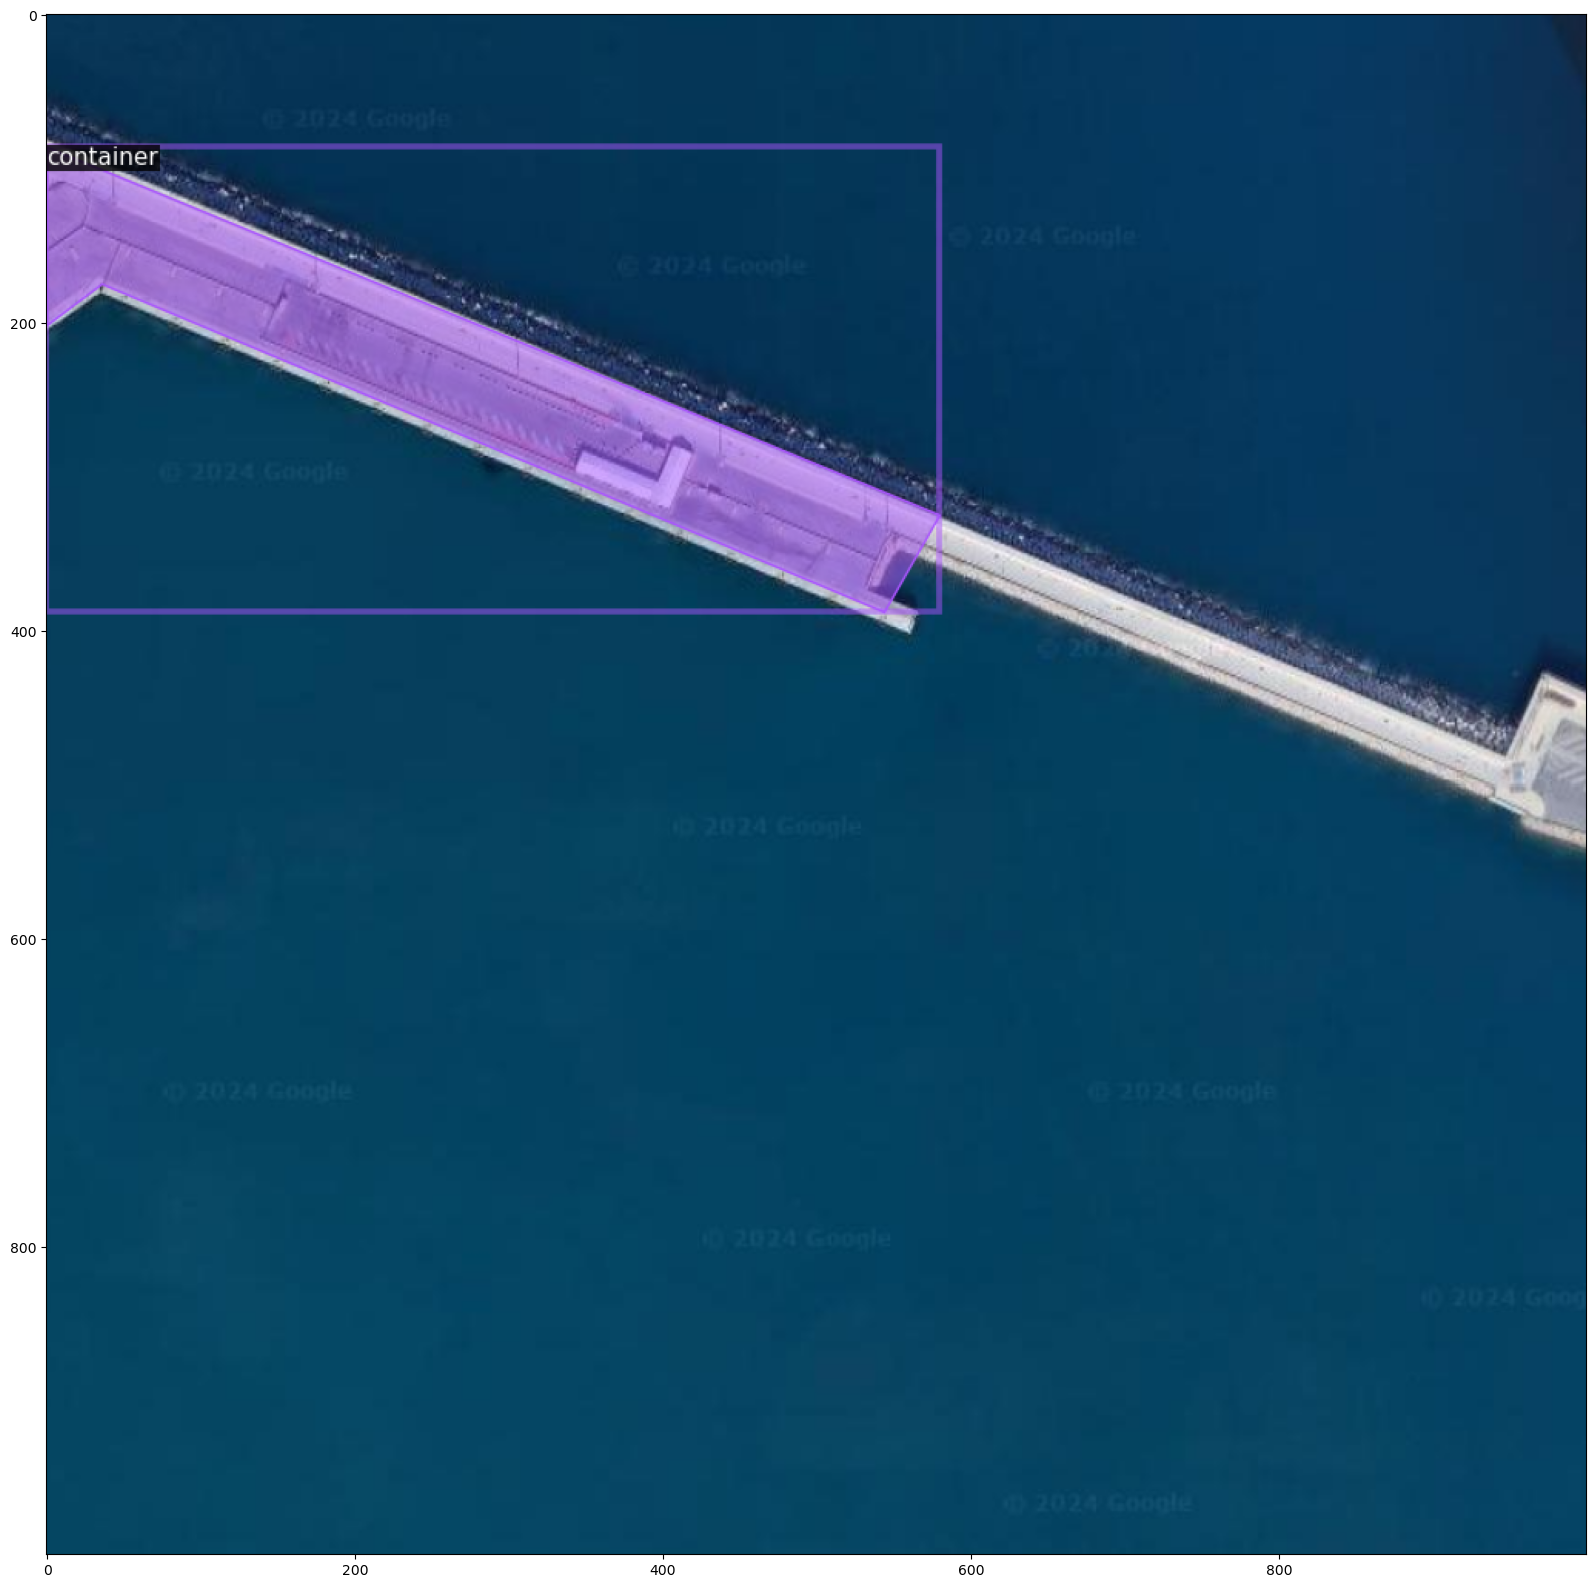

In [14]:
### Visualise annotations & images of trainning dataset ###
#The functions are located in train.py 

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../Satellite/train", annotation_json)    
random_visu(dataset_dicts, metadata, 1)

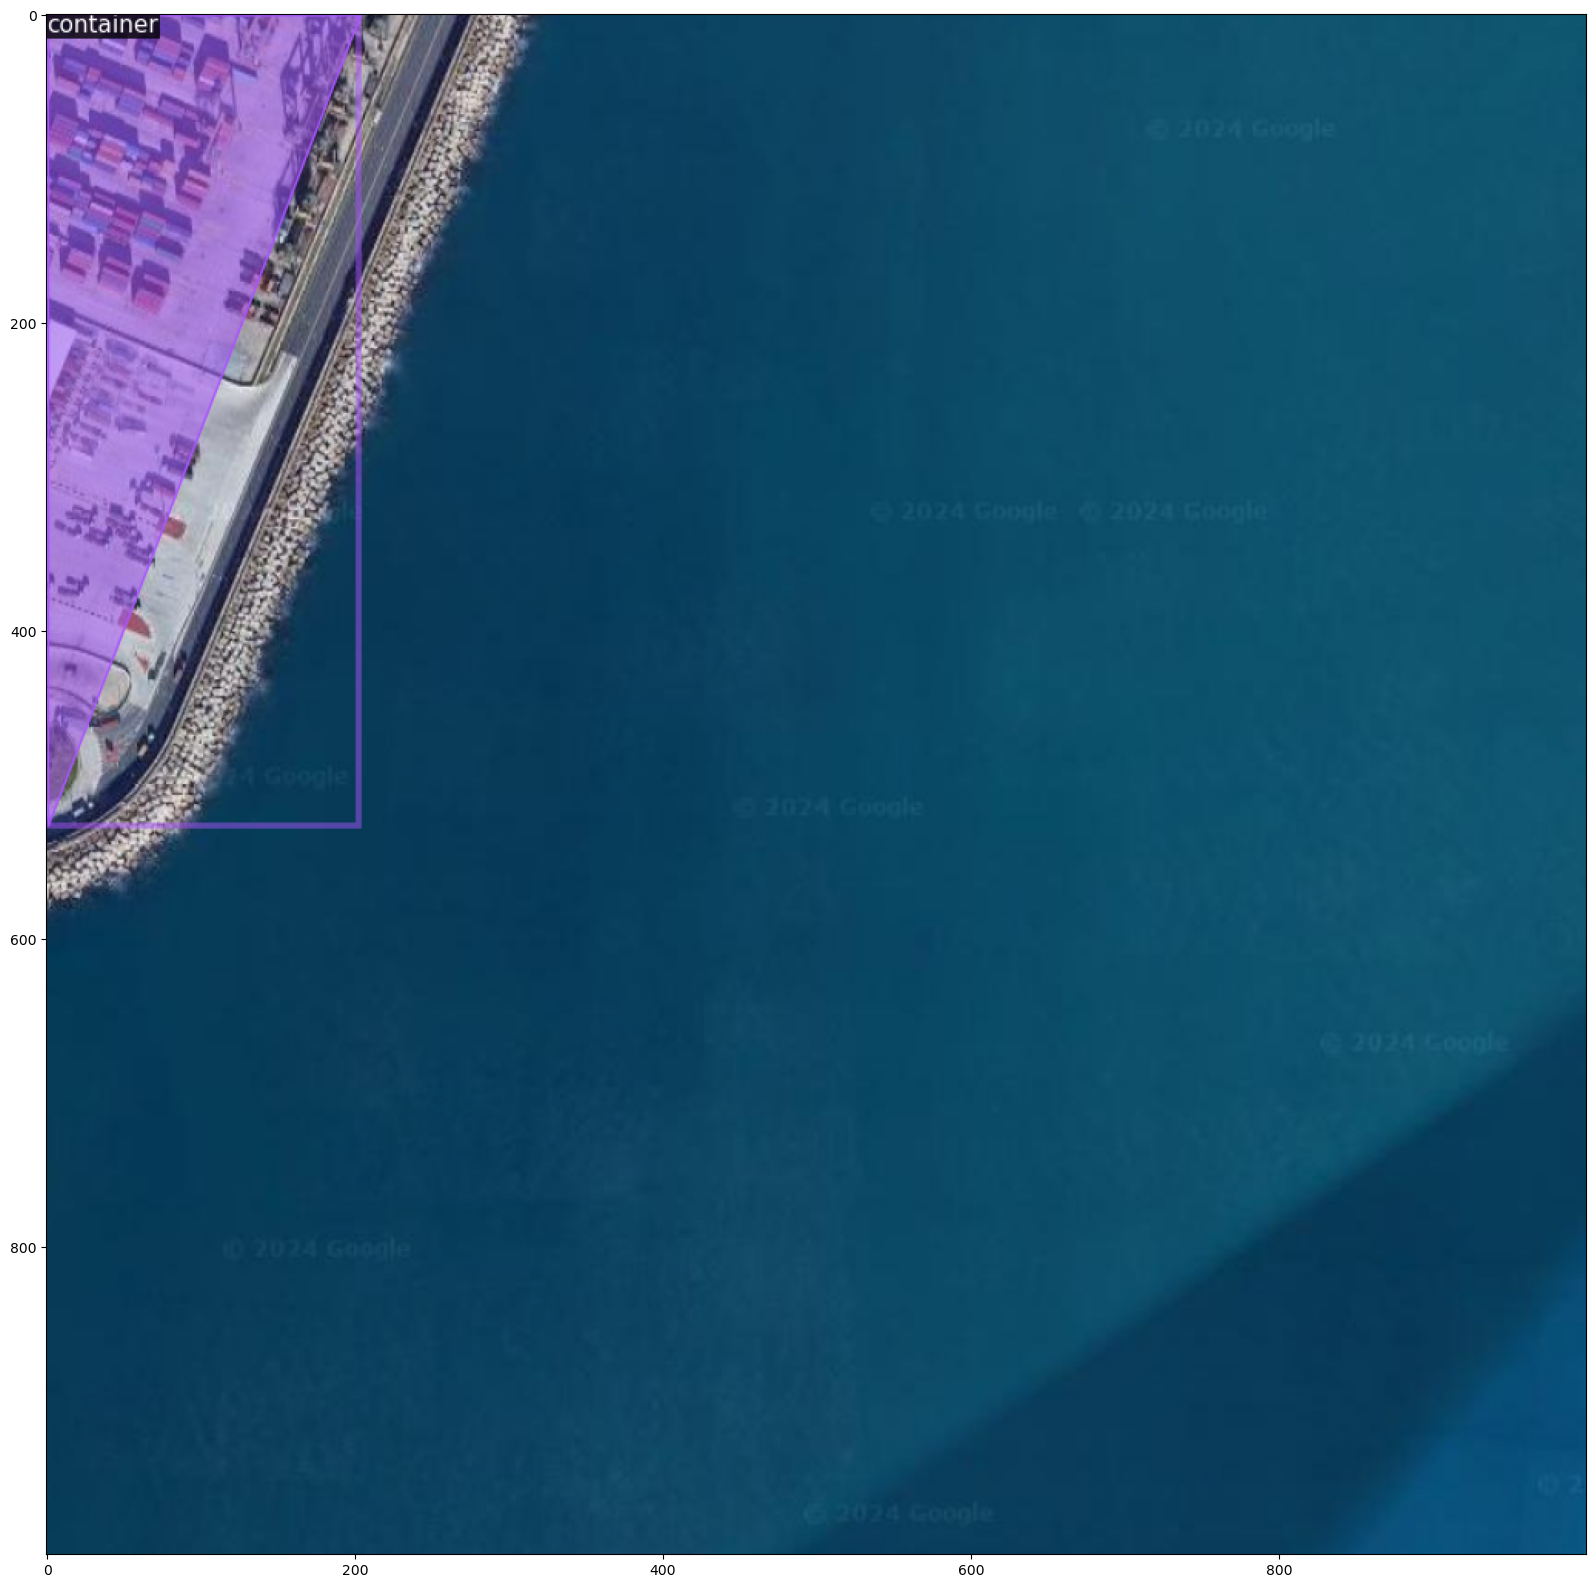

In [15]:
### Visualise annotations & images of trainning dataset ###
#The functions are located in train.py 

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../Satellite/train", annotation_json)    
random_visu(dataset_dicts, metadata, 1)

In [16]:
### Make D2 configuration  ###

cfg = setup_cfg(base_model=base_model_, trains=trains_, tests=tests_, workers=workers_, base_lr=base_lr_, eval_period=eval_period_, warm_iter=warm_iter_,
                ims_per_batch=ims_per_batch_, max_iter=max_iter_, out_dir=out_dir_, filter_empty_annot=filter_empty_annot_)
# update_model arg can be used to load already trained model
#cfg.INPUT.MIN_SIZE_TRAIN = 1000

# Save your configurations
with open(os.path.join(out_dir, conf_file), "w") as file:
    yaml.dump(cfg, file)
print(cfg.dump())

In [17]:
### Set up logging with Wandb ###

## If cfg is not defined, load it from yaml file: ##
#config = load_yaml(os.path.join(out_dir, conf_file))
#wandb.login()

# COMMENT OUT: AttributeError: module 'cgi' has no attribute 'escape': requirements tensorboard>=2.4.0 #167
#%load_ext tensorboard
#%tensorboard --logdir output

# Give the same name as output subfolder and confname - no need for wandb.login() at beginning if wand.init() is used
os.environ["WANDB_NOTEBOOK_NAME"] = "config_train_evaluate.ipynb"
wandb.init(
    project='P1',
    sync_tensorboard=True,
    save_code=True,
    config=cfg,
    name=experiment_name,
    notes=annotation_json,
    settings=wandb.Settings(
        start_method="thread",
        console="off"
    )
)

# Never worked:
#%env "WANDB_NOTEBOOK_NAME" "config_train_evaluate"